<a href="https://colab.research.google.com/github/ipeirotis/dealing_with_data/blob/master/03-Pandas/A2-Introduction_to_Pandas-NYPD_Vehicle_Collisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Pandas

## Setup and preliminaries

In [ ]:
!pip3 install -U -q PyMySQL sqlalchemy sql_magic xlrd

# Render our plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Make the graphs a bit bigger
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])

## Exercise: NYPD Vehicle Collisions

* We interacted with the NYC Restaurant Inspection Data. Now, let's download another dataset, and do some analysis. We will focus on the [NYPD Vehicle Collisions](https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95/data) data set.


### Task 1: 

Load the dataset. We will need to load two tables:
* `collisions`
* `vehicles_involved`


In [11]:
import os
from sqlalchemy import create_engine

conn_string = 'mysql+pymysql://{user}:{password}@{host}/{db}?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org', 
    user = 'student',
    password = 'dwdstudent2015', 
    db = 'collisions',
    encoding = 'utf8mb4')

mysql_conn = create_engine(conn_string).connect()

In [ ]:
# This query returns back the collisions table
sql = '''
    #YOUR CODE HERE
'''
c = pd.read_sql(sql, con=mysql_conn)
c

In [ ]:
# This query returns back the vehicles_involved table
sql = '''
    #YOUR CODE HERE
'''
v = pd.read_sql(sql, con=mysql_conn)
v

#### Solution

In [13]:
# This query returns back the collisions table
sql = '''
	SELECT * 
  FROM collisions
'''
c = pd.read_sql(sql, con=mysql_conn)
c

,UNIQUE_KEY,DATE_TIME,LATITUDE,LONGITUDE,ZIPCODE,NEIGHBORHOOD,BOROUGH,PERSONS_INJURED,PERSONS_KILLED,PEDESTRIANS_INJURED,PEDESTRIANS_KILLED,CYCLISTS_INJURED,CYCLISTS_KILLED,MOTORISTS_INJURED,MOTORISTS_KILLED,ON_STREET_NAME,CROSS_STREET_NAME,OFF_STREET_NAME,REPORTED_ZIPCODE,REPORTED_BOROUGH
0,0000022,2012-07-01 10:40:00,40.720854,-74.003929,10013,SoHo-TriBeCa-Civic Center-Little Italy,Manhattan,0,0,0,0,0,0,0,0,CANAL STREET,WOOSTER STREET,None,10013,MANHATTAN
1,0000023,2012-07-01 12:18:00,40.704799,-74.016685,10280,park-cemetery-etc-Manhattan,Manhattan,0,0,0,0,0,0,0,0,BATTERY PLACE,WEST STREET,None,10004,MANHATTAN
2,0000024,2012-07-01 15:00:00,NaN,NaN,None,None,None,0,0,0,0,0,0,0,0,WATER STREET,OLD SLIP,None,None,None
3,0000025,2012-07-01 18:00:00,40.713692,-74.013754,10007,SoHo-TriBeCa-Civic Center-Little Italy,Manhattan,0,0,0,0,0,0,0,0,WEST STREET,VESEY STREET,None,10007,MANHATTAN
4,0000026,2012-07-01 19:30:00,40.719058,-74.012442,10013,SoHo-TriBeCa-Civic Center-Little Italy,Manhattan,0,0,0,0,0,0,0,0,WEST STREET,HARRISON STREET,None,10013,MANHATTAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882900,4537408,2022-06-09 09:30:00,NaN,NaN,None,None,None,0,0,0,0,0,0,0,0,None,None,2315 STRAUSS STREET,11212,BROOKLYN
1882901,4537409,2022-06-09 16:27:00,40.670660,-73.904205,11212,Brownsville,Brooklyn,0,0,0,0,0,0,0,0,PITKIN AVENUE,POWELL STREET,None,11212,BROOKLYN
1882902,4537412,2022-06-11 22:25:00,40.663670,-73.912130,11212,Brownsville,Brooklyn,3,0,0,0,0,0,3,0,DUMONT AVENUE,BOYLAND STREET,None,11212,BROOKLYN
1882903,4537413,2022-06-06 00:00:00,40.655148,-73.910940,11212,Rugby-Remsen Village,Brooklyn,0,0,0,0,0,0,0,0,None,None,601 AMBOY STREET,11212,BROOKLYN


In [14]:
# This query returns back the vehicles_involved table
sql = '''
	SELECT * 
  FROM vehicles_involved
'''
v = pd.read_sql(sql, con=mysql_conn)
v

,UNIQUE_KEY,VEHICLE,CAUSE,VEHICLE_TYPE
0,0000022,1,UNSPECIFIED,SPORT UTILITY / STATION WAGON
1,0000022,2,UNSPECIFIED,VAN
2,0000023,1,UNSPECIFIED,TAXI
3,0000023,2,UNSPECIFIED,TAXI
4,0000024,1,OVERSIZED VEHICLE,BUS
...,...,...,...,...
3579049,4537412,1,UNSAFE SPEED,SPORT UTILITY / STATION WAGON
3579050,4537412,2,UNSPECIFIED,SEDAN
3579051,4537413,1,DRIVER INATTENTION/DISTRACTION,SPORT UTILITY / STATION WAGON
3579052,4537421,1,UNSPECIFIED,SEDAN


In [ ]:
c.dtypes

In [16]:
v.dtypes

UNIQUE_KEY      object
VEHICLE          int64
CAUSE           object
VEHICLE_TYPE    object
dtype: object

### Task 2: 

Find out the most common contributing factors to the collisions. 
 

#### Solution

In [21]:
# Task 2: Find out the most common contributing factors to the collisions.
v['CAUSE'].value_counts() #.plot(kind='barh')

UNSPECIFIED                                              2096410
DRIVER INATTENTION/DISTRACTION                            455010
FAILURE TO YIELD RIGHT-OF-WAY                             125231
FOLLOWING TOO CLOSELY                                     118156
OTHER VEHICULAR                                            91621
BACKING UNSAFELY                                           78500
PASSING OR LANE USAGE IMPROPER                             60961
FATIGUED/DROWSY                                            58988
TURNING IMPROPERLY                                         55204
PASSING TOO CLOSELY                                        52908
UNSAFE LANE CHANGING                                       43259
TRAFFIC CONTROL DISREGARDED                                37934
DRIVER INEXPERIENCE                                        34958
UNSAFE SPEED                                               26395
LOST CONSCIOUSNESS                                         25353
PAVEMENT SLIPPERY        

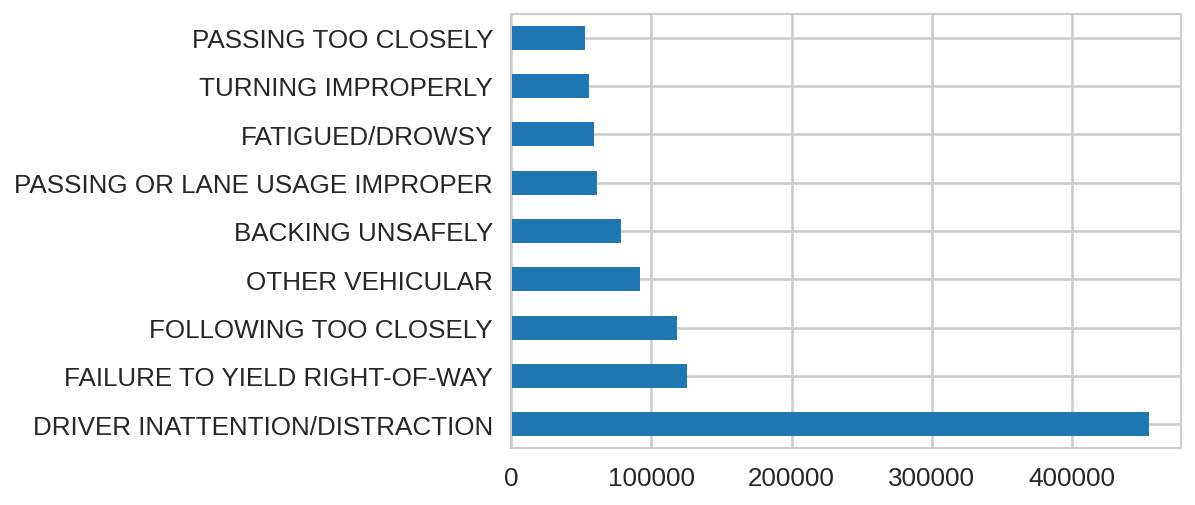

In [20]:
# Task 2: If we want to remove the "Unspecified", we select the elements starting
# from position 1 (i.e., the second element in the list, the first one is 0)
v['CAUSE'].value_counts()[1:10].plot(kind='barh')

### Task 3: 

Break down the number of collisions by borough.





#### Solution

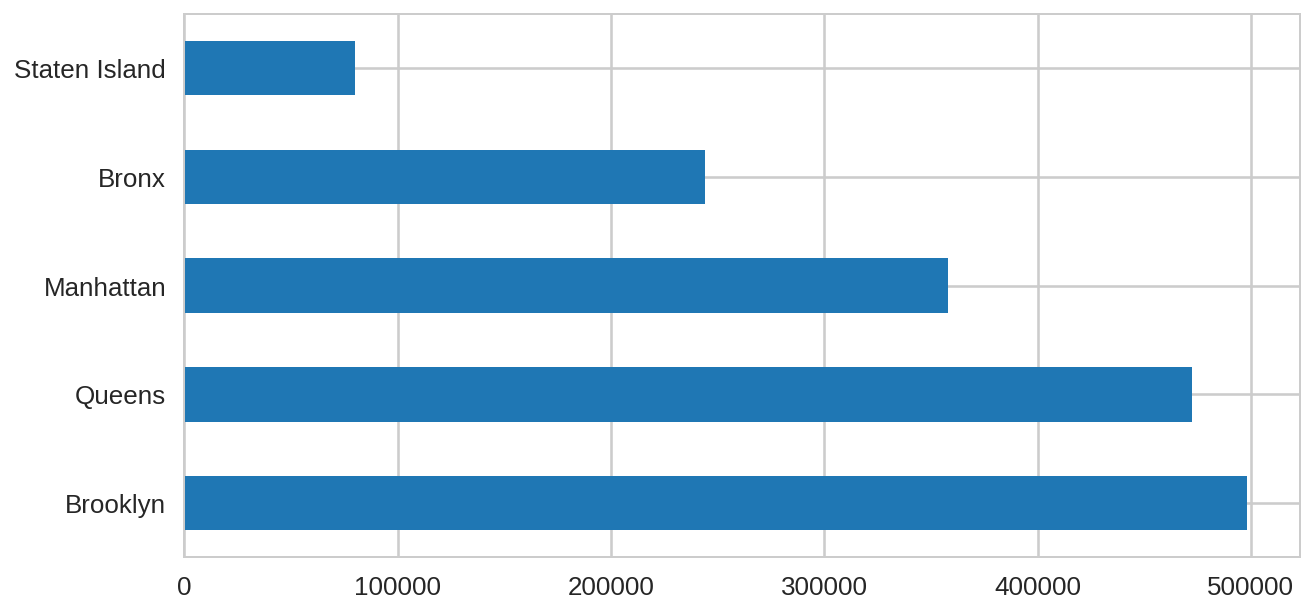

In [22]:
# Task 3: Break down the number of collisions by borough.
c['BOROUGH'].value_counts().plot(kind='barh', figsize=(10,5))

### Task 4

Find out the how many collisions had 0 persons injured, 1 persons injured, etc. persons injured in each accident. Use the `value_counts()` approach. You may also find the `.plot(logy=True)` option useful when you create the plot to make the y-axis logarigthmic.
 

#### Solution

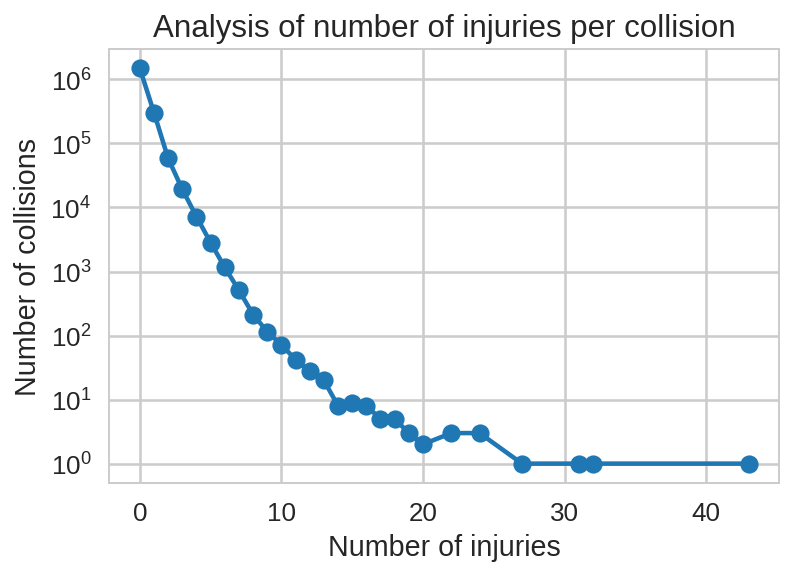

In [24]:
# "Chain" style of writing data maniputation operations
plot = (
    c['PERSONS_INJURED'] # take the num of injuries column
    .value_counts() # compure the freuquency of each value
    .sort_index() # sort the results based on the index value instead of the frequency, 
                  # which is the default for value_counts
    .plot( # and plot the results
        kind='line', # we use a line plot because the x-axis is numeric/continuous
        marker='o',  # we use a marker to mark where we have data points 
        logy=True # make the y-axis logarithmic
    )
)
plot.set_xlabel("Number of injuries")
plot.set_ylabel("Number of collisions")
plot.set_title("Analysis of number of injuries per collision")
pass

### Task 5

(a) Compute the average number of injuries and deaths per accident, broken down by borough. Use the `pivot_table` functionality, putting `BOROUGH` as the index. You can answer this query by generating two separate tables, or you can create a single table by using the fact that you can pass a list of attributes/columns to the `values` parameter of the pivot table.

(b) Repeat the exercise above, but break down the average number of deaths and injuries using the cause for the accident. (Do not worry that each accident may have multiple causes.) You will need to **join** the tables `collisions` and `vehicles_involves`; you can do the join either in SQL or in pandas, using the `pd.merge` command. Use the `sort_values` command to sort the results, putting on top the contributing factors that generate the highest number of deaths. Limit to the 10-deadliest causes.

#### Solution

In [25]:
pd.pivot_table(
    data = c,
    index = 'BOROUGH',
    aggfunc = 'mean',
    values = ['PERSONS_INJURED', 'PERSONS_KILLED']
)

,PERSONS_INJURED,PERSONS_KILLED
BOROUGH,,
Bronx,0.321765,0.001472
Brooklyn,0.316689,0.001278
Manhattan,0.205204,0.001051
Queens,0.292476,0.001406
Staten Island,0.276943,0.001523


In [26]:
# By keeping only the minimum attributes that we need, we speed up
# the execution, as we do not bring back data that we will discard anyway
sql = '''
  SELECT C.PERSONS_INJURED, C.PERSONS_KILLED, V.CAUSE
  FROM collisions C JOIN vehicles_involved V ON C.UNIQUE_KEY = V.UNIQUE_KEY
'''
result = pd.read_sql(sql, con=mysql_conn)

In [28]:
pd.pivot_table(
    data = result,
    index = 'CAUSE',
    aggfunc = 'mean',
    values = ['PERSONS_INJURED', 'PERSONS_KILLED']
).sort_values('PERSONS_KILLED', ascending=False).head(10)

,PERSONS_INJURED,PERSONS_KILLED
CAUSE,,
ILLNESS,0.447132,0.012968
UNSAFE SPEED,0.671756,0.011972
PEDESTRIAN/BICYCLIST/OTHER PEDESTRIAN ERROR/CONFUSION,0.765017,0.009217
DRUGS (ILLEGAL),0.621785,0.007564
TRAFFIC CONTROL DISREGARDED,0.664338,0.006116
PASSENGER DISTRACTION,0.522155,0.005901
TINTED WINDOWS,0.555556,0.005848
ALCOHOL INVOLVEMENT,0.480444,0.004604
OTHER LIGHTING DEFECTS,0.465753,0.004566


### Task 6

Break down the number of accidents by borough and contributing factor. Use the `pivot_table` function of Pandas
 

#### Solution

In [32]:
# By keeping only the minimum attributes that we need, we speed up
# the execution, as we do not bring back data that we will discard anyway
sql = '''
  SELECT C.BOROUGH,  V.CAUSE, COUNT(DISTINCT C.UNIQUE_KEY) AS cnt
  FROM collisions C JOIN vehicles_involved V ON C.UNIQUE_KEY = V.UNIQUE_KEY
  GROUP BY C.BOROUGH,  V.CAUSE
'''
result = pd.read_sql(sql, con=mysql_conn)

In [33]:
pivot = pd.pivot_table(
    data = result, # we analyze the df (accidents) dataframe
    index = 'CAUSE', 
    columns = 'BOROUGH', 
    values = 'cnt', 
    aggfunc = 'sum'
)

# Create an extra column showing the total deaths across boroughs (=columns)
pivot["Total"] = pivot.sum(axis="columns") 

# Sort the dataframe by descending order of the values in the column "Total"
pivot = pivot.sort_values("Total", ascending=False)

pivot.head(10)

BOROUGH,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Total
CAUSE,,,,,,
UNSPECIFIED,189002.0,404764.0,256876.0,378077.0,63936.0,1292655.0
DRIVER INATTENTION/DISTRACTION,43121.0,94070.0,83602.0,106629.0,19959.0,347381.0
FAILURE TO YIELD RIGHT-OF-WAY,12106.0,33770.0,18148.0,38493.0,4918.0,107435.0
FOLLOWING TOO CLOSELY,14095.0,24555.0,17454.0,32148.0,4474.0,92726.0
BACKING UNSAFELY,10112.0,20141.0,13757.0,21732.0,3652.0,69394.0
OTHER VEHICULAR,12756.0,13023.0,24033.0,9567.0,1870.0,61249.0
PASSING OR LANE USAGE IMPROPER,6694.0,14173.0,12987.0,14240.0,1513.0,49607.0
PASSING TOO CLOSELY,7431.0,15255.0,11180.0,11484.0,1082.0,46432.0
TURNING IMPROPERLY,6444.0,11199.0,14245.0,10970.0,1812.0,44670.0


### Task 7

Find the dates with the most accidents. Can you figure out what happened on these days? 


#### Solution

In [40]:
(
  pd.pivot_table(
      data = c,
      index = 'DATE_TIME',
      values = 'UNIQUE_KEY',
      aggfunc = 'count'
  )
  .resample('1D').sum()
  .rename({"UNIQUE_KEY":"ACCIDENTS"}, axis="columns")
  .sort_values('ACCIDENTS')
)

,ACCIDENTS
DATE_TIME,
2020-04-05,92
2020-04-19,100
2020-04-09,102
2020-04-12,105
2020-04-23,107
...,...
2015-01-18,961
2017-05-19,970
2017-12-15,992


### Task 8

Plot the number of accidents per day. (Hint: Ensure that your date column is in the right datatype and that it is properly sorted, before plotting)


#### Solution 

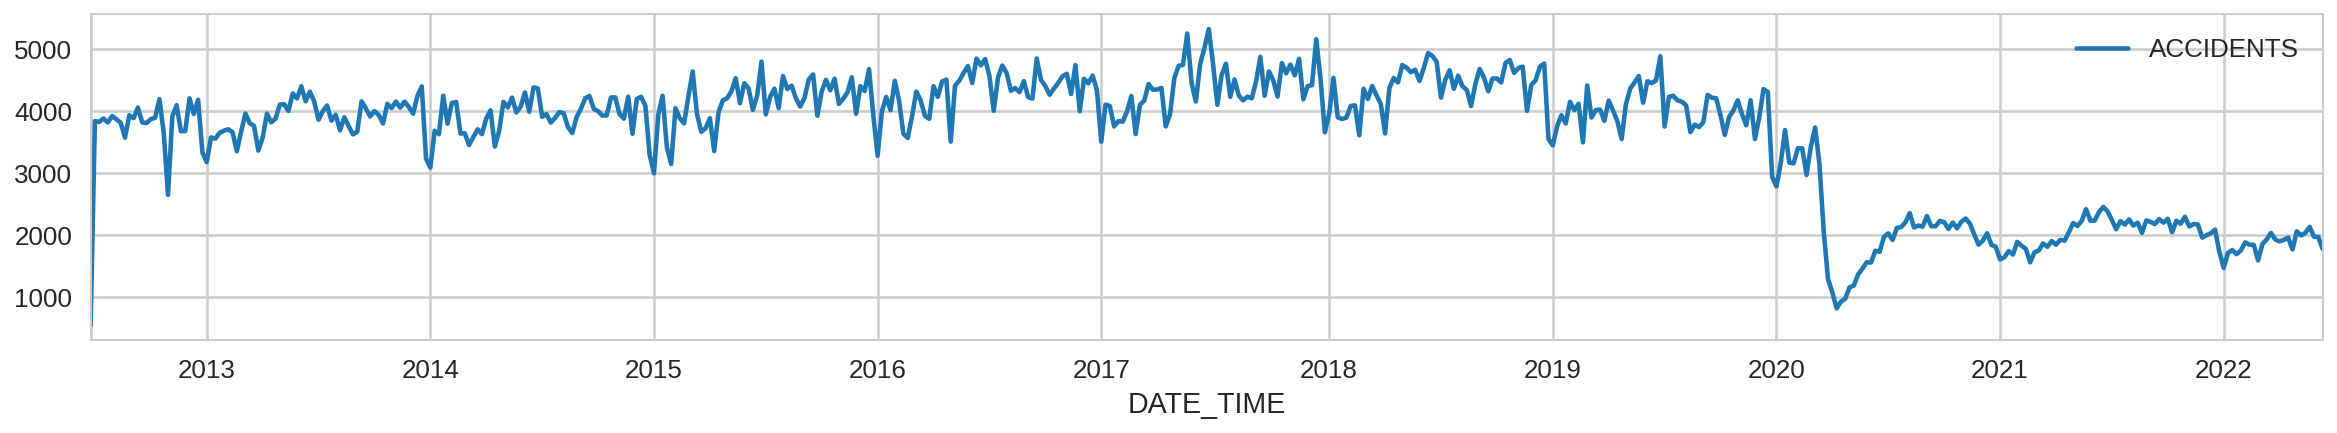

In [42]:
(
  pd.pivot_table(
      data = c,
      index = 'DATE_TIME',
      values = 'UNIQUE_KEY',
      aggfunc = 'count'
  )
  .resample('1W') # take periods of 1 week
  .sum() # sum the number of accidents per period
  .rename({"UNIQUE_KEY":"ACCIDENTS"}, axis="columns") # change the name of the variable
  .plot(figsize=(20,3)) # plot the result
)



### Task 9

We want to analyze the timing patterns of accidents that lead to death or injury.

We will do the analysis by creating histograms showing the frequency of deadly vs non-deadly accidents throughout the day. By comparing the two histograms we will be able to understand if time of day is correlated with deadly accidents or not.

Steps to follow:
* Ensure that the `CRASH TIME` column is converted to a datetime. The format is HH:MM, which can be written as `format="%H:%M"` in the `to_datetime` command of Pandas.
* Create a boolean column `DEATH` that is true when someone was killed in the accident (i.e., `NUMBER OF PERSONS KILLED > 0`). 
* Create a boolean column `INJURY` that is true when someone was injured in the accident (i.e., `NUMBER OF PERSONS INJURED > 0`). 
* Query the dataframe to get back the deadly accidents and create a histogram of deadly accidents over time. Do the same for non-deadly accidents.
* To allow a more direct visual comparison of the two histograms, we want to merge them in one plot. Since the number of accidents without deaths is *much* higher, we want the histograms to be normalized (i.e., `density=True`). 
* It is also a good idea to make the histographs partially transparent, to allow for easier comparison of the two histograms.


### Solution

In [ ]:
# Define the indicator variables
df['INJURY'] = (df['NUMBER OF PERSONS INJURED']>0)
df['DEATH'] = (df['NUMBER OF PERSONS KILLED']>0)

df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'], format="%H:%M")

In [ ]:
# Define the two subsets
deadly_accidents = df[ df['DEATH'] == True ]
noharm_accidents = df[ df['DEATH'] == False ]

In [ ]:
deadly_accidents['CRASH TIME'].hist(
    bins=48, # one bar per half hour
    figsize=(20,10),  # make the figure bigger
    density=True, # normalize the counts
    alpha=0.5,  # make the histogram semi-transparent
    color='red' # color red the deadly accidents
)

noharm_accidents['CRASH TIME'].hist(
    bins=48,
    figsize=(20,10), 
    density=True,
    alpha=0.5, 
    color='green'
)

In [ ]:
injuries = df[ df['INJURY'] == True ]
no_injuries = df[ df['INJURY'] == False ]

In [ ]:
injuries['CRASH TIME'].hist(bins=48,figsize=(20,10), density=True,alpha=0.5, color='red')
no_injuries['CRASH TIME'].hist(bins=48,figsize=(20,10), density=True,alpha=0.5, color='green')

In [ ]:
deadly_accidents['CRASH DATE'].hist(bins=48,figsize=(20,10), density=True,alpha=0.5, color='red')
noharm_accidents['CRASH DATE'].hist(bins=48,figsize=(20,10), density=True,alpha=0.5, color='green')

In [ ]:
injuries['CRASH DATE'].hist(bins=48,figsize=(20,10), density=True,alpha=0.5, color='red')
no_injuries['CRASH DATE'].hist(bins=48,figsize=(20,10), density=True,alpha=0.5, color='green')

In [ ]:
import seaborn as sns

In [ ]:
sns.kdeplot(data = df, x ='CRASH TIME', hue='DEATH', common_norm=False, cut=0)

In [ ]:
sns.kdeplot(data = df, x ='CRASH TIME', hue='INJURY', common_norm=False, cut=0)